In [110]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

import string

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk import word_tokenize

from IPython.display import display

print(torch.__version__)


1.12.1


In [84]:
DATA_DIR = "data/shakespear.txt"


def load_preprocess_data():
    with open(DATA_DIR, "r") as f:
        data = [l.rstrip().lower() for l in f.readlines()]
    
    data = [line.translate(str.maketrans('', '', string.punctuation)) for line in data]
    data = [word_tokenize(line) for line in data]

    return data

def remove_stopwords(data, sw=stopwords.words("english")):
    res = []
    for line in data:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res

data = load_preprocess_data()
data_clean = remove_stopwords(data)

display(data[:2])
print("=" * 30)
display(data_clean[:2])


[['that',
  'poor',
  'contempt',
  'or',
  'claimd',
  'thou',
  'slept',
  'so',
  'faithful'],
 ['i',
  'may',
  'contrive',
  'our',
  'father',
  'and',
  'in',
  'their',
  'defeated',
  'queen']]

[['poor', 'contempt', 'claimd', 'thou', 'slept', 'faithful'],
 ['may', 'contrive', 'father', 'defeated', 'queen']]

### Models from scratch

No softmax due to [nn.CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [123]:
def get_output_shape(model, image_dim):
    return model(torch.randint(0, 500, size=image_dim)).data.shape


In [133]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size: int, embed_size: int = 300):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.out = torch.nn.Linear(embed_size, vocab_size)

    def forward(self, idxs):
        X = self.embedding(idxs).mean(1)
        X = self.out(X)
        return F.softmax(X, dim=1)

cbow_model = CBOW(10_000)
get_output_shape(cbow_model, [1, 5])


torch.Size([1, 10000])

In [136]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size: int, embed_size: int = 300):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.out = torch.nn.Linear(embed_size, vocab_size)

    def forward(self, idxs):
        X = self.embedding(idxs)
        X = self.out(X)
        return X

skip_gramm_model = SkipGram(10_000)
get_output_shape(skip_gramm_model, [1, 5])


torch.Size([1, 5, 10000])

### Negative Sampling

### Embedding dimentionality

In [85]:
model_4 = Word2Vec(sentences=data_clean, vector_size=4, window=3, min_count=1, workers=4, sg=1)
model_20 = Word2Vec(sentences=data, vector_size=20, window=3, min_count=1, workers=4, sg=1)
model_100 = Word2Vec(sentences=data, vector_size=100, window=3, min_count=1, workers=4, sg=1)


[[ 98.70701   -13.0007715]
 [ 93.239975   34.976707 ]
 [ 67.087074  -35.784184 ]
 ...
 [-82.909355   55.57658  ]
 [ 79.89904    -1.9042798]
 [-22.337145   27.466337 ]]


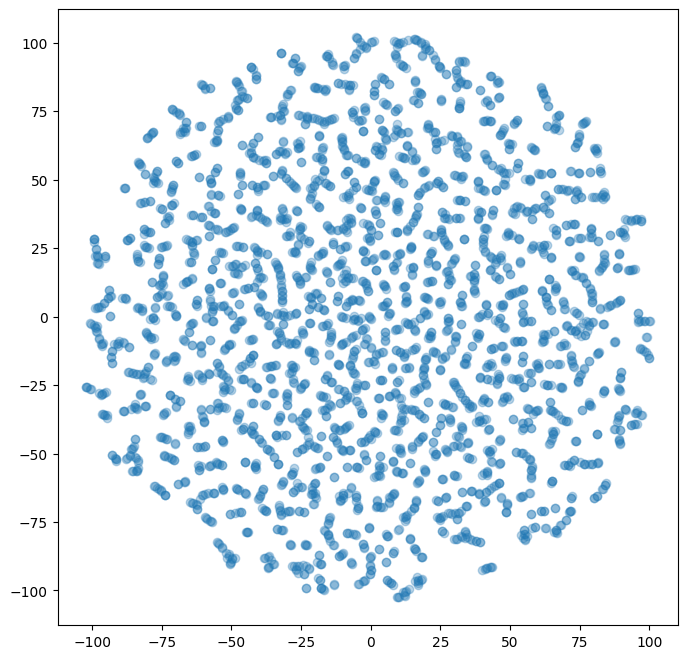

In [86]:
from sklearn.manifold import TSNE

def plot_tsne(X):
    X_tr = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
    print(X_tr)
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tr[:, 0], X_tr[:, 1], alpha=0.3)
    plt.show()

plot_tsne(model_4.wv.vectors)


[[ 66.90327    -58.22578   ]
 [ 67.94429    -60.376842  ]
 [ 78.83968    -53.689938  ]
 ...
 [-28.72187    -16.926275  ]
 [ 16.962498    -0.66611844]
 [-50.4804     -51.629635  ]]


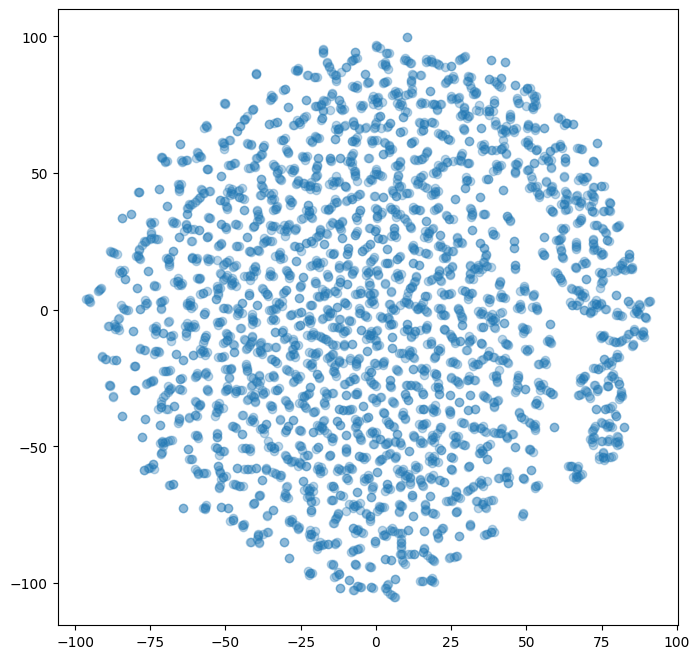

In [87]:
plot_tsne(model_20.wv.vectors)


[[ -7.680794  -95.48415  ]
 [ -9.797296  -94.29831  ]
 [ 28.309547  -85.62211  ]
 ...
 [ 65.421745   -3.2846553]
 [ 12.991252  -51.420128 ]
 [  8.66624    -6.0645304]]


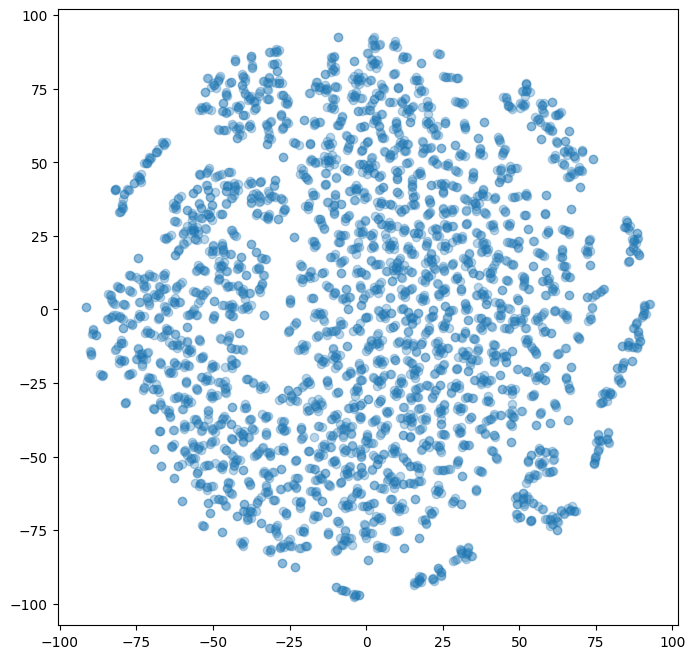

In [88]:
plot_tsne(model_100.wv.vectors)
